<a href="https://colab.research.google.com/github/multikokoiti1998/vgg_8_3/blob/k-fold/Alexnet_grand_cam_8_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
from tqdm import tqdm
import random
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision
from PIL import Image
import torch.nn as nn
import torch
import pandas as pd
from sklearn.model_selection import KFold,train_test_split
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torch.utils.data import Dataset
from pathlib import Path
from typing import List, Tuple
from pathlib import Path
import xml.etree.ElementTree as ET
import torchvision.models as models
import torch.optim as optim

In [ ]:
# 画像ディレクトリと画像パスの取得
image_directory = '/content/drive/MyDrive/lernig/obiref88/image'
label_directory = '/content/drive/MyDrive/lernig/obiref88/label'

def update_xml_paths(image_directory: str, label_directory: str):
    image_paths = []
    labels = []

    # 画像ファイルとXMLファイルの一致確認
    for image_file in os.listdir(image_directory):
        if image_file.endswith('.jpg'):
            base_name = image_file.replace('.jpg', '')

            xml_path = Path(label_directory) / f"{base_name}.xml"

            if xml_path.exists():
                tree = ET.parse(xml_path)
                root = tree.getroot()
                label = root.find('.//name')
                image_paths.append(os.path.join(image_directory, image_file))
                labels.append(label.text)

    return image_paths, labels

image_paths, labels = update_xml_paths(image_directory, label_directory)
print("Number of image paths:", len(image_paths))
print("Number of labels:", len(labels))


Number of image paths: 300
Number of labels: 300


In [ ]:
data_transform = {
    'train': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(degrees=[-15, 15]),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ]),
    'val': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ])
}



In [ ]:
label_mapping = {
    'ok': 0,
    'out': 1
}
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = [label_mapping[label] for label in labels]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert('RGB')
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
            label=torch.tensor(label)
        return image, label


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
num_epochs=100
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_dataset=[]
val_dataset=[]
total_train_accs=[]
total_val_accs=[]
data_size = {'train': len(train_dataset), 'val': len(val_dataset)}

In [ ]:
def train_model(model, criterion, optimizer, num_epochs):

        for epoch in range(num_epochs):
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / data_size[phase]
                epoch_acc = corrects.double() / data_size[phase]

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

              #print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        train_accs_cpu = [acc.cpu().numpy() for acc in train_accs]
        val_accs_cpu = [acc.cpu().numpy() for acc in val_accs]

        plot_training_history(train_losses, val_losses, train_accs_cpu, val_accs_cpu)



def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    # Lossのプロット
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracyのプロット
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0.4, 1)
    plt.tight_layout()
    plt.show()


In [ ]:
net = torchvision.models.alexnet(pretrained=True)

#for param in net.parameters():
          #param.requires_grad = False

# モデルをGPUに移動

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# 損失関数と最適化アルゴリズムを定義(MSE）
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

# モデルのトレーニングと評価
model = net
base_path = r'/content/drive/MyDrive/learning'
folder_name = 'weight'
directory_path = os.path.join(base_path, folder_name)
file_name = 'alexnet.pth'
file_path = os.path.join(base_path, folder_name, file_name)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print("Length of image_paths:", len(image_paths))
print("Length of labels:", len(labels))

Length of image_paths: 300
Length of labels: 300


==========Cross Validation Fold 1==========
trainLoss: 0.7538 Acc: 0.4688
valLoss: 0.6461 Acc: 0.7292
trainLoss: 0.6235 Acc: 0.6927
valLoss: 0.6061 Acc: 0.6875
trainLoss: 0.5891 Acc: 0.7188
valLoss: 0.5935 Acc: 0.6875
trainLoss: 0.5789 Acc: 0.7188
valLoss: 0.5791 Acc: 0.6875
trainLoss: 0.5811 Acc: 0.7292
valLoss: 0.5681 Acc: 0.7083
trainLoss: 0.5844 Acc: 0.7135
valLoss: 0.5638 Acc: 0.7292
trainLoss: 0.5383 Acc: 0.7188
valLoss: 0.5566 Acc: 0.7292
trainLoss: 0.5436 Acc: 0.7240
valLoss: 0.5459 Acc: 0.7083
trainLoss: 0.5426 Acc: 0.7604
valLoss: 0.5378 Acc: 0.7708
trainLoss: 0.5280 Acc: 0.7448
valLoss: 0.5436 Acc: 0.8333
trainLoss: 0.4859 Acc: 0.7708
valLoss: 0.5216 Acc: 0.7708
trainLoss: 0.5112 Acc: 0.7865
valLoss: 0.5194 Acc: 0.7917
trainLoss: 0.5008 Acc: 0.7500
valLoss: 0.5132 Acc: 0.8333
trainLoss: 0.5017 Acc: 0.7865
valLoss: 0.5250 Acc: 0.8542
trainLoss: 0.4932 Acc: 0.7812
valLoss: 0.4983 Acc: 0.8125
trainLoss: 0.4619 Acc: 0.7865
valLoss: 0.4956 Acc: 0.8333
trainLoss: 0.4750 Acc: 0.791

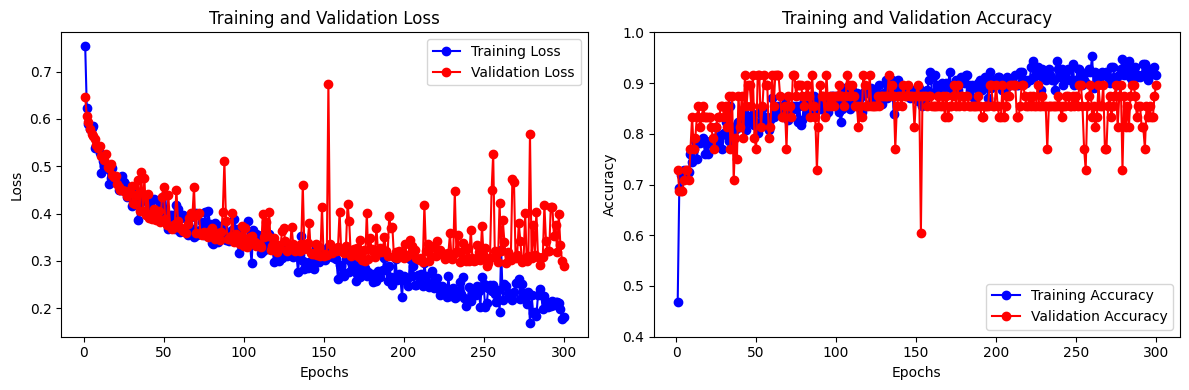

Train done.
Train saved.
Accuracy of the network on the test images: 40 %
Accuracy of the network on the test images: 78 %
==========Cross Validation Fold 2==========
trainLoss: 0.6337 Acc: 0.6250
valLoss: 0.4551 Acc: 0.7917
trainLoss: 0.4836 Acc: 0.8021
valLoss: 0.4029 Acc: 0.7917
trainLoss: 0.4460 Acc: 0.8125
valLoss: 0.3792 Acc: 0.8750
trainLoss: 0.4169 Acc: 0.8594
valLoss: 0.3509 Acc: 0.8958
trainLoss: 0.3937 Acc: 0.8594
valLoss: 0.3352 Acc: 0.8750
trainLoss: 0.3883 Acc: 0.8542
valLoss: 0.3125 Acc: 0.8958
trainLoss: 0.3468 Acc: 0.8594
valLoss: 0.3047 Acc: 0.8958
trainLoss: 0.3746 Acc: 0.8542
valLoss: 0.2976 Acc: 0.8750
trainLoss: 0.3514 Acc: 0.8698
valLoss: 0.3077 Acc: 0.8542
trainLoss: 0.3383 Acc: 0.8646
valLoss: 0.2898 Acc: 0.8958
trainLoss: 0.3498 Acc: 0.8646
valLoss: 0.2815 Acc: 0.8958
trainLoss: 0.2998 Acc: 0.8802
valLoss: 0.2732 Acc: 0.8958
trainLoss: 0.3103 Acc: 0.8854
valLoss: 0.2789 Acc: 0.8958
trainLoss: 0.3163 Acc: 0.8854
valLoss: 0.2942 Acc: 0.8542
trainLoss: 0.3298 Acc

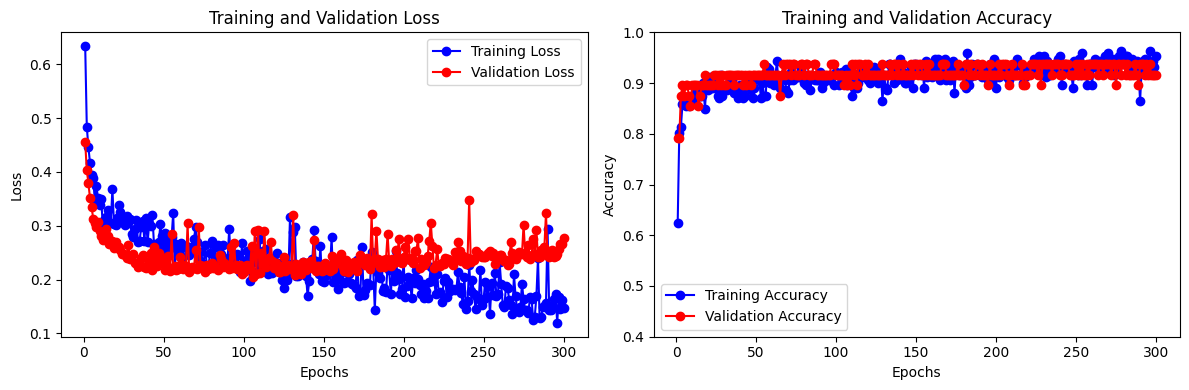

Train done.
Train saved.
Accuracy of the network on the test images: 36 %
Accuracy of the network on the test images: 76 %
==========Cross Validation Fold 3==========
trainLoss: 0.6673 Acc: 0.6354
valLoss: 0.4364 Acc: 0.8542
trainLoss: 0.4708 Acc: 0.8125
valLoss: 0.3814 Acc: 0.9167
trainLoss: 0.4264 Acc: 0.8125
valLoss: 0.3396 Acc: 0.9167
trainLoss: 0.4100 Acc: 0.8385
valLoss: 0.2992 Acc: 0.9167
trainLoss: 0.4032 Acc: 0.8490
valLoss: 0.2875 Acc: 0.8958
trainLoss: 0.3864 Acc: 0.8333
valLoss: 0.2654 Acc: 0.9167
trainLoss: 0.3398 Acc: 0.8698
valLoss: 0.2503 Acc: 0.9167
trainLoss: 0.3394 Acc: 0.8750
valLoss: 0.2417 Acc: 0.9167
trainLoss: 0.3203 Acc: 0.8646
valLoss: 0.2356 Acc: 0.9167
trainLoss: 0.3248 Acc: 0.8750
valLoss: 0.2437 Acc: 0.9167
trainLoss: 0.3222 Acc: 0.8750
valLoss: 0.2478 Acc: 0.9167
trainLoss: 0.3152 Acc: 0.8802
valLoss: 0.2209 Acc: 0.9167
trainLoss: 0.2948 Acc: 0.8906
valLoss: 0.2203 Acc: 0.9375
trainLoss: 0.2884 Acc: 0.8854
valLoss: 0.2276 Acc: 0.9167
trainLoss: 0.2646 Acc

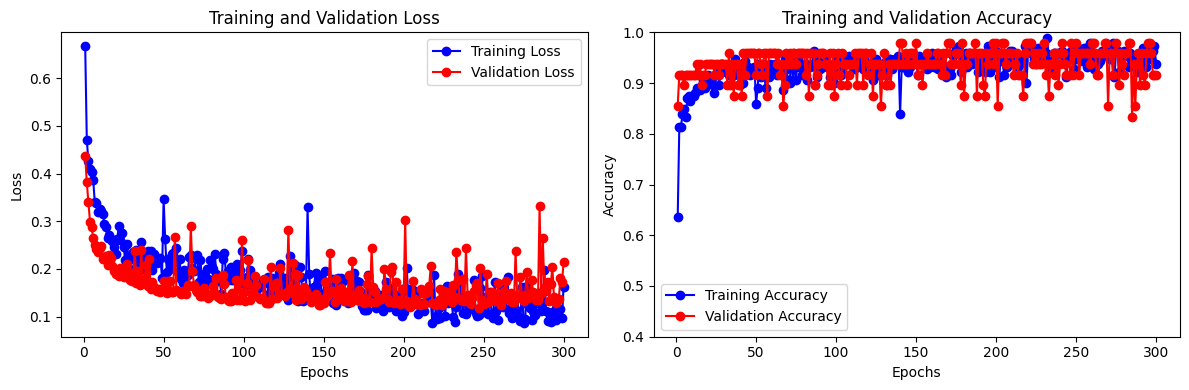

Train done.
Train saved.
Accuracy of the network on the test images: 38 %
Accuracy of the network on the test images: 70 %
==========Cross Validation Fold 4==========
trainLoss: 0.4895 Acc: 0.7448
valLoss: 0.4296 Acc: 0.8333
trainLoss: 0.3817 Acc: 0.8490
valLoss: 0.3657 Acc: 0.8958
trainLoss: 0.3678 Acc: 0.8490
valLoss: 0.3212 Acc: 0.8958
trainLoss: 0.3439 Acc: 0.8698
valLoss: 0.2955 Acc: 0.9167
trainLoss: 0.2906 Acc: 0.8854
valLoss: 0.2745 Acc: 0.9167
trainLoss: 0.2902 Acc: 0.8958
valLoss: 0.2614 Acc: 0.8958
trainLoss: 0.2803 Acc: 0.9062
valLoss: 0.2559 Acc: 0.9167
trainLoss: 0.2672 Acc: 0.9219
valLoss: 0.2335 Acc: 0.8958
trainLoss: 0.2963 Acc: 0.8802
valLoss: 0.2335 Acc: 0.9167
trainLoss: 0.2746 Acc: 0.9167
valLoss: 0.2213 Acc: 0.8958
trainLoss: 0.2486 Acc: 0.9115
valLoss: 0.2304 Acc: 0.9167
trainLoss: 0.2524 Acc: 0.9167
valLoss: 0.2187 Acc: 0.9167
trainLoss: 0.2440 Acc: 0.9115
valLoss: 0.2022 Acc: 0.8958
trainLoss: 0.2255 Acc: 0.9167
valLoss: 0.1939 Acc: 0.9167
trainLoss: 0.2328 Acc

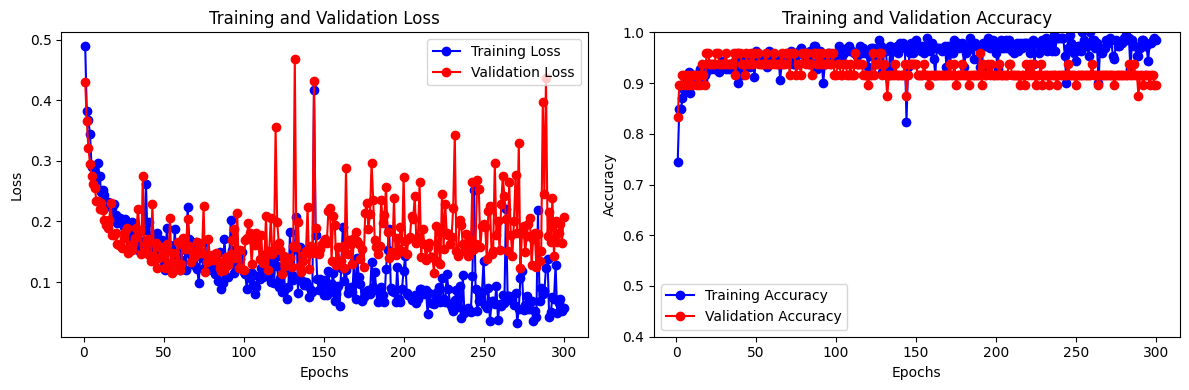

Train done.
Train saved.
Accuracy of the network on the test images: 43 %
Accuracy of the network on the test images: 76 %
==========Cross Validation Fold 5==========
trainLoss: 0.6037 Acc: 0.6562
valLoss: 0.4575 Acc: 0.7917
trainLoss: 0.3580 Acc: 0.8646
valLoss: 0.3627 Acc: 0.7917
trainLoss: 0.2866 Acc: 0.9115
valLoss: 0.4284 Acc: 0.7917
trainLoss: 0.3103 Acc: 0.9167
valLoss: 0.3175 Acc: 0.7917
trainLoss: 0.2342 Acc: 0.9323
valLoss: 0.2762 Acc: 0.8958
trainLoss: 0.2619 Acc: 0.9167
valLoss: 0.2752 Acc: 0.8958
trainLoss: 0.2294 Acc: 0.9375
valLoss: 0.2509 Acc: 0.8958
trainLoss: 0.2271 Acc: 0.9271
valLoss: 0.2359 Acc: 0.8958
trainLoss: 0.2650 Acc: 0.9167
valLoss: 0.2694 Acc: 0.8750
trainLoss: 0.1734 Acc: 0.9323
valLoss: 0.1837 Acc: 0.9583
trainLoss: 0.1948 Acc: 0.9323
valLoss: 0.1941 Acc: 0.9167
trainLoss: 0.2096 Acc: 0.9167
valLoss: 0.2772 Acc: 0.8542
trainLoss: 0.1836 Acc: 0.9375
valLoss: 0.1790 Acc: 0.9583
trainLoss: 0.1999 Acc: 0.9375
valLoss: 0.1780 Acc: 0.9375
trainLoss: 0.1611 Acc

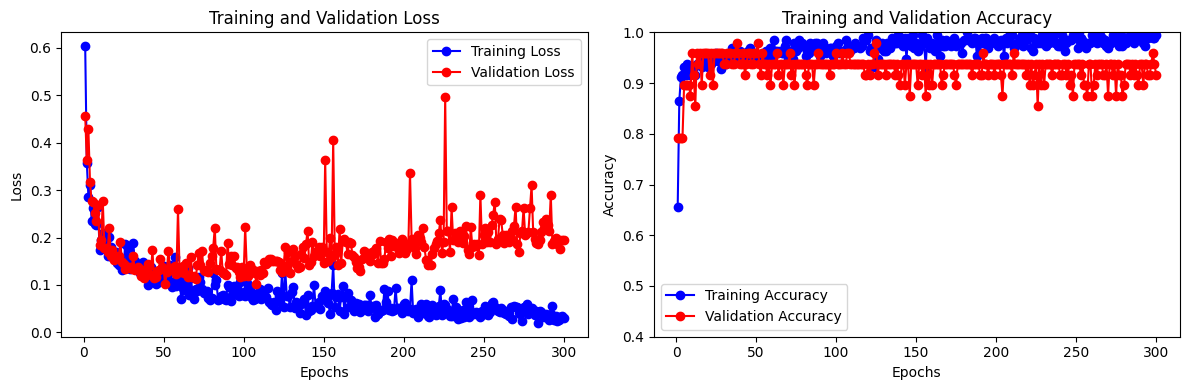

Train done.
Train saved.
Accuracy of the network on the test images: 41 %
Accuracy of the network on the test images: 75 %


In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
train_val_index, test_index = train_test_split(range(len(image_paths)), test_size=0.2, random_state=42)
train_val_paths= [image_paths[i] for i in train_val_index]
train_val_labels = [labels[i] for i in train_val_index]
test_paths= [image_paths[i] for i in test_index]
test_labels = [labels[i] for i in test_index]
test_dataset = ImageDataset(test_paths, test_labels, transform=data_transform['val'])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
# データセットの分割とデータローダーの作成
for fold, (train_index, val_index) in enumerate(kfold.split(range(len(train_val_index))), 1):
    print(f'==========Cross Validation Fold {fold}==========')
    image_directory = '/content/drive/MyDrive/lernig/OBI_ref/image'
    label_directory = '/content/drive/MyDrive/lernig/OBI_ref/label'


    image_paths, labels = update_xml_paths(image_directory, label_directory)
    train_paths = [image_paths[i] for i in train_index]
    train_labels = [labels[i] for i in train_index]
    val_paths = [image_paths[i] for i in val_index]
    val_labels = [labels[i] for i in val_index]

    train_dataset = ImageDataset(train_paths, train_labels, transform=data_transform['train'])
    val_dataset = ImageDataset(val_paths, val_labels, transform=data_transform['val'])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    dataloaders  = {"train":train_loader, "val":val_loader}

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # 事前学習済みモデルの全結合層の出力ユニット数をデータのクラス数に置き換え
    num_classes = len(set(train_labels))
    net.classifier[6] = nn.Linear(4096, num_classes)

# ここでデータローダーを使用して学習や検証を行う
    data_size = {'train': len(train_dataset), 'val': len(val_dataset)}
    train_model(model, criterion, optimizer, num_epochs)
    print('Train done.')
    file_path = os.path.join(directory_path, f'{file_name}_{str(fold)}.pth')
    # モデルの保存
    torch.save(model.state_dict(), file_path)
    print('Train saved.')
    model.load_state_dict(torch.load(file_path))
    model.eval()
    model.to(device)

    correct = 0
    total = 0
    with torch.no_grad():
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          correct += (predicted == labels).sum().item()
          print('Accuracy of the network on the test images: %d %%' % (100 * correct / 60))

